# INTRODUCTION


#### Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

#### Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

# *************************************************************************************************************************


#### La première partie nous a permis de réaliser un nettoyage des données et une courte analyse exploratoire.
#### Dans cette seconde partie, nous allons réaliser les diverses modélisations grâce à des approches linéaires et non-linéaire afin de prédire les émissions de CO2 et les consommations d'énergie des bâtiments.

# Sommaire

 ### 1.Preprocessing
   #### 1.1. Encodage et standardisation
   #### 1.2. Préparation des jeux d'entrainement et de test

 ### 2.Modèle Baseline : Régression linéaire multivariée

 ### 3.Modèle linéaires : ElasticNet et SVR
   #### 3.1. Modèle ElasticNet
   #### 3.2. Modèle Support Vector Regression (SVR)

 ### 4.Modèle non-linéaires : XGBoost et RandomForestRegressor
   #### 4.1. Modèle RandomForestRegressor
   #### 4.2. Modèle XGBoost (eXtreme Gradient Boosting)

 ### 5.Sélection des meilleurs modèles
  #### 5.1. Modèle de prédiction des émissions de CO2
  #### 5.2. Modèle de prédiction des consommations d'énergie

 ### 6.Test des modèles sélectionnés
  #### 6.1. Prédiction des émissions de CO2
  #### 6.2. Prédiction des consommation d'énergie

 ### 7.Influence du score ENERGY STAR

# 1. Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/buildindataset/building-energy-cleaned.csv
/kaggle/input/buildingdatasetplus/building-energy-cleaned (2).csv
/kaggle/input/sea-building-energy-datasets/2016-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-datasets/socrata_metadata_2016-building-energy-benchmarking.json
/kaggle/input/sea-building-energy-datasets/2015-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-datasets/socrata_metadata_2015-building-energy-benchmarking.json


## Importons les données nettoyées

In [2]:
data = pd.read_csv("../input/buildingdatasetplus/building-energy-cleaned (2).csv")
data.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,LargestPropertyUseType,NumberofBuildings,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance
0,325,2015,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,98101.0,DOWNTOWN,Unknown,1.0,...,9899135.0,0.0,69.01,1,1.00000,0.00000,111077.0,27769.250,26,0.439292
1,400,2015,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,98101.0,DOWNTOWN,Office,1.0,...,6488262.0,37893.0,47.24,1,0.73651,0.26349,98370.0,16395.000,109,0.236408
2,442,2015,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,98109.0,LAKE UNION,Office,1.0,...,16760914.0,0.0,116.84,5,0.80466,0.19534,193788.0,48447.000,68,1.171413
3,499,2015,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,98144.0,GREATER DUWAMISH,Office,1.0,...,2234200.0,2242889.0,134.69,2,0.72049,0.27951,76598.0,25532.667,7,2.924194
4,559,2015,NonResidential,Large Office,YALE & THOMAS,325 EASTLAKE AVE E,98109.0,LAKE UNION,Office,1.0,...,9657951.0,3004906.0,226.92,2,1.00000,0.00000,186971.0,46742.750,34,1.044201


### Comme nous l'avons vu dans l'analyse exploratoire, un modèle simple de régression linéaire multivarié ne pourrait pas répondre totalement à notre problème de prédiction. Nous allons donc utiliser ce premier modèle comme baseline et tester les métriques principales : R² et MAE.

In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           1697 non-null   int64  
 1   DataYear                1697 non-null   int64  
 2   BuildingType            1697 non-null   object 
 3   PrimaryPropertyType     1697 non-null   object 
 4   PropertyName            1697 non-null   object 
 5   Address                 1697 non-null   object 
 6   ZipCode                 1681 non-null   float64
 7   Neighborhood            1697 non-null   object 
 8   LargestPropertyUseType  1697 non-null   object 
 9   NumberofBuildings       1697 non-null   float64
 10  NumberofFloors          1697 non-null   float64
 11  PropertyGFATotal        1697 non-null   float64
 12  ENERGYSTARScore         1154 non-null   float64
 13  SiteEnergyUse(kBtu)     1697 non-null   float64
 14  SteamUse(kBtu)          1697 non-null   

In [4]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance
count,1697.000000,1697.000000,1681.000000,1697.000000,1697.000000,1.697000e+03,1154.000000,1.697000e+03,1.697000e+03,1.697000e+03,1.697000e+03,1697.000000,1697.000000,1697.000000,1697.000000,1.697000e+03,1697.000,1697.000000,1697.000000
mean,16335.021803,2015.982911,98116.796550,1.148792,4.103712,1.183821e+05,64.951906,8.457072e+06,5.133132e+05,5.865634e+06,1.971806e+06,185.235053,1.890395,0.937434,0.062566,1.096056e+05,inf,54.272834,2.806912
std,13813.723285,0.129641,18.361263,2.810985,6.518106,2.952745e+05,28.041709,3.010387e+07,5.351773e+06,2.069226e+07,9.400898e+06,745.538021,1.221760,0.139156,0.139156,1.876920e+05,NaN,32.853508,2.212459
min,1.000000,2015.000000,98006.000000,0.500000,0.000000,1.128500e+04,1.000000,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.120000,1.000000,-0.251160,-0.000010,7.166667e+03,221.697,1.000000,0.021130
25%,584.000000,2016.000000,98105.000000,1.000000,1.000000,2.939200e+04,46.500000,1.215360e+06,0.000000e+00,7.328030e+05,0.000000e+00,20.150000,1.000000,1.000000,0.000000,2.918600e+04,13259.500,27.000000,0.868029
50%,21150.000000,2016.000000,98109.000000,1.000000,2.000000,4.925200e+04,72.500000,2.555917e+06,0.000000e+00,1.649172e+06,4.974050e+05,50.215000,2.000000,1.000000,0.000000,4.928000e+04,22980.000,51.000000,2.282484
75%,24602.000000,2016.000000,98124.000000,1.000000,4.000000,1.067720e+05,88.000000,6.960904e+06,0.000000e+00,4.871044e+06,1.507822e+06,139.630000,2.000000,1.000000,0.000000,1.040990e+05,38221.000,86.000000,4.236630
max,50226.000000,2016.000000,98199.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.314066e+08,6.570744e+08,2.979090e+08,16870.980000,13.000000,1.000010,1.251160,2.761918e+06,inf,116.000000,8.843544


In [5]:
# Regardons les valeurs infinies et corrigeons les
data[(data.GFAPerBuilding == np.inf) | (data.GFAPerFloor == np.inf)].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,LargestPropertyUseType,NumberofBuildings,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance
192,267,2016,NonResidential,Hotel,Grand Hyatt Seattle,721 Pine St,98101.0,DOWNTOWN,Hotel,1.0,...,39516051.5,24913925.5,1598.655,5,1.00000,0.00000,934292.0,inf,17,0.455683
506,656,2016,NonResidential,Medical Office,Arnold Pavilion,1221 Madison Street,98104.0,EAST,Medical Office,1.0,...,12268893.0,0.0,648.285,1,1.00000,0.00000,225982.0,inf,12,0.491603
507,657,2016,NonResidential,Mixed Use Property,2200 Westlake - SEDO,2200 Westlake Ave.,98121.0,DOWNTOWN,Parking,0.5,...,29657760.5,14535043.5,978.705,7,1.00000,0.00000,1032814.0,inf,10,0.838548
578,758,2016,NonResidential,Other,Pacific Place,600 Pine Street,98101.0,DOWNTOWN,Other - Mall,1.0,...,47328085.0,0.0,329.940,4,0.76783,0.23217,947987.0,inf,17,0.485479
1103,23311,2016,NonResidential,Medical Office,HART First Hill LLC,1124 Columbia Street,98104.0,EAST,Medical Office,1.0,...,11948708.5,0.0,1112.250,2,1.00000,0.00000,274568.0,inf,71,0.424374


In [6]:
data[(data.TotalGHGEmissions == np.inf) | (data.TotalGHGEmissions == np.inf)].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,LargestPropertyUseType,NumberofBuildings,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance


In [7]:
data['GFAPerBuilding'] = np.where(((data.GFAPerBuilding == np.inf) & (data.NumberofBuildings == 0)),0, data.GFAPerBuilding)
data['GFAPerFloor'] = np.where(((data.GFAPerFloor == np.inf) & (data.NumberofFloors == 0)),0, data.GFAPerFloor)

In [8]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance
count,1697.000000,1697.000000,1681.000000,1697.000000,1697.000000,1.697000e+03,1154.000000,1.697000e+03,1.697000e+03,1.697000e+03,1.697000e+03,1697.000000,1697.000000,1697.000000,1697.000000,1.697000e+03,1.697000e+03,1697.000000,1697.000000
mean,16335.021803,2015.982911,98116.796550,1.148792,4.103712,1.183821e+05,64.951906,8.457072e+06,5.133132e+05,5.865634e+06,1.971806e+06,185.235053,1.890395,0.937434,0.062566,1.096056e+05,3.354322e+04,54.272834,2.806912
std,13813.723285,0.129641,18.361263,2.810985,6.518106,2.952745e+05,28.041709,3.010387e+07,5.351773e+06,2.069226e+07,9.400898e+06,745.538021,1.221760,0.139156,0.139156,1.876920e+05,4.699243e+04,32.853508,2.212459
min,1.000000,2015.000000,98006.000000,0.500000,0.000000,1.128500e+04,1.000000,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.120000,1.000000,-0.251160,-0.000010,7.166667e+03,0.000000e+00,1.000000,0.021130
25%,584.000000,2016.000000,98105.000000,1.000000,1.000000,2.939200e+04,46.500000,1.215360e+06,0.000000e+00,7.328030e+05,0.000000e+00,20.150000,1.000000,1.000000,0.000000,2.918600e+04,1.296000e+04,27.000000,0.868029
50%,21150.000000,2016.000000,98109.000000,1.000000,2.000000,4.925200e+04,72.500000,2.555917e+06,0.000000e+00,1.649172e+06,4.974050e+05,50.215000,2.000000,1.000000,0.000000,4.928000e+04,2.263460e+04,51.000000,2.282484
75%,24602.000000,2016.000000,98124.000000,1.000000,4.000000,1.067720e+05,88.000000,6.960904e+06,0.000000e+00,4.871044e+06,1.507822e+06,139.630000,2.000000,1.000000,0.000000,1.040990e+05,3.766780e+04,86.000000,4.236630
max,50226.000000,2016.000000,98199.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.314066e+08,6.570744e+08,2.979090e+08,16870.980000,13.000000,1.000010,1.251160,2.761918e+06,1.100000e+06,116.000000,8.843544


#### Regardons maintenant l'effet de la surface totale GFAsur nos varaibles a predire:        

    TotalGHGEmissions   ,  SiteEnergyUse(kBtu)   ,     ENERGYSTARScore 

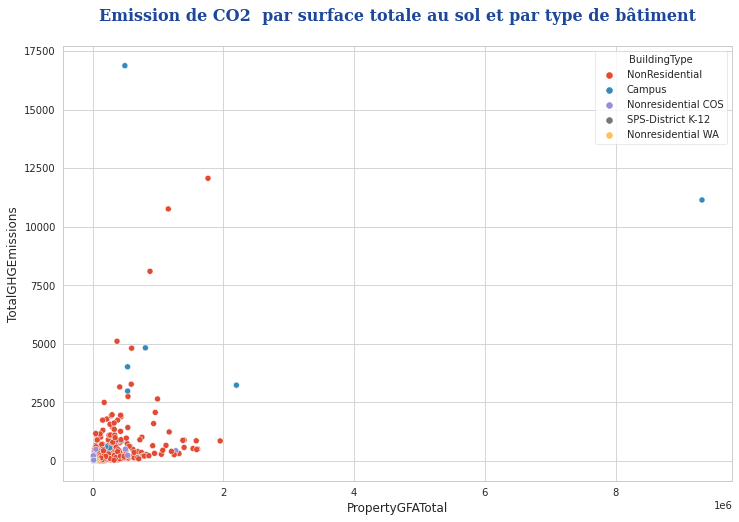

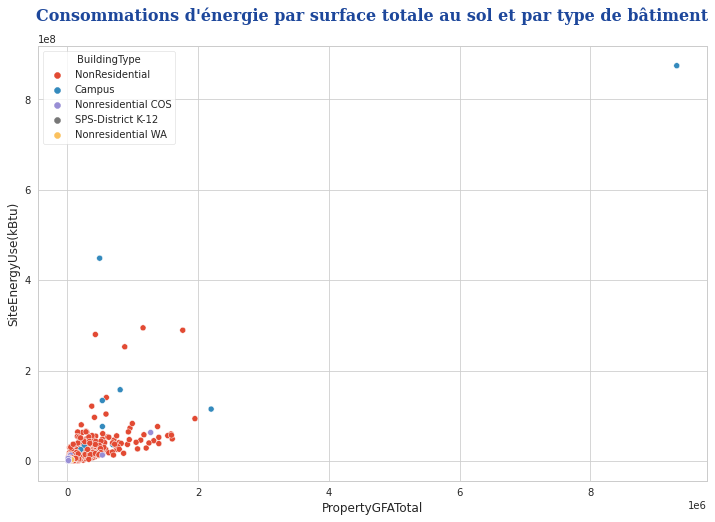

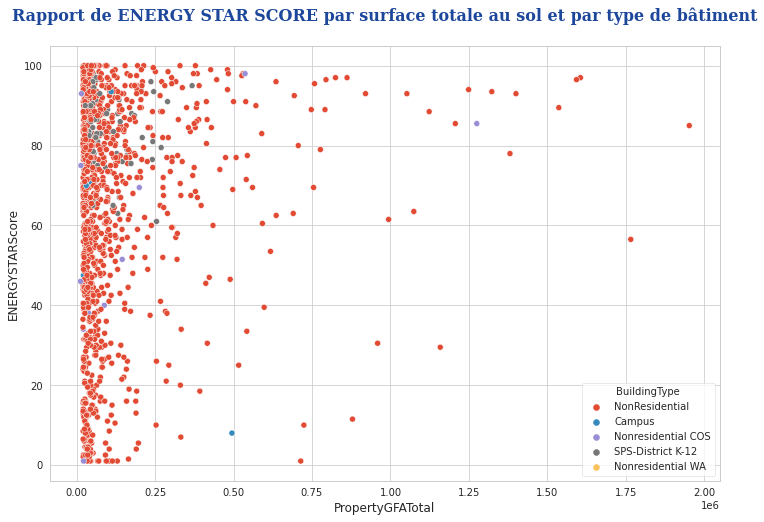

In [9]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='PropertyGFATotal', y='TotalGHGEmissions', hue='BuildingType')
plt.title(f"Emission de CO2  par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='PropertyGFATotal', y='ENERGYSTARScore', hue='BuildingType')
plt.title(f"Rapport de ENERGY STAR SCORE par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)
plt.show()

In [10]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'ZipCode', 'Neighborhood',
       'LargestPropertyUseType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'TotalUseTypeNumber', 'GFABuildingRate',
       'GFAParkingRate', 'GFAPerBuilding', 'GFAPerFloor', 'BuildingAge',
       'harvesine_distance'],
      dtype='object')

In [11]:
numerical_features =  [  'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'TotalUseTypeNumber', 'GFABuildingRate',
       'GFAParkingRate', 'GFAPerBuilding', 'GFAPerFloor', 'BuildingAge',
       'harvesine_distance']

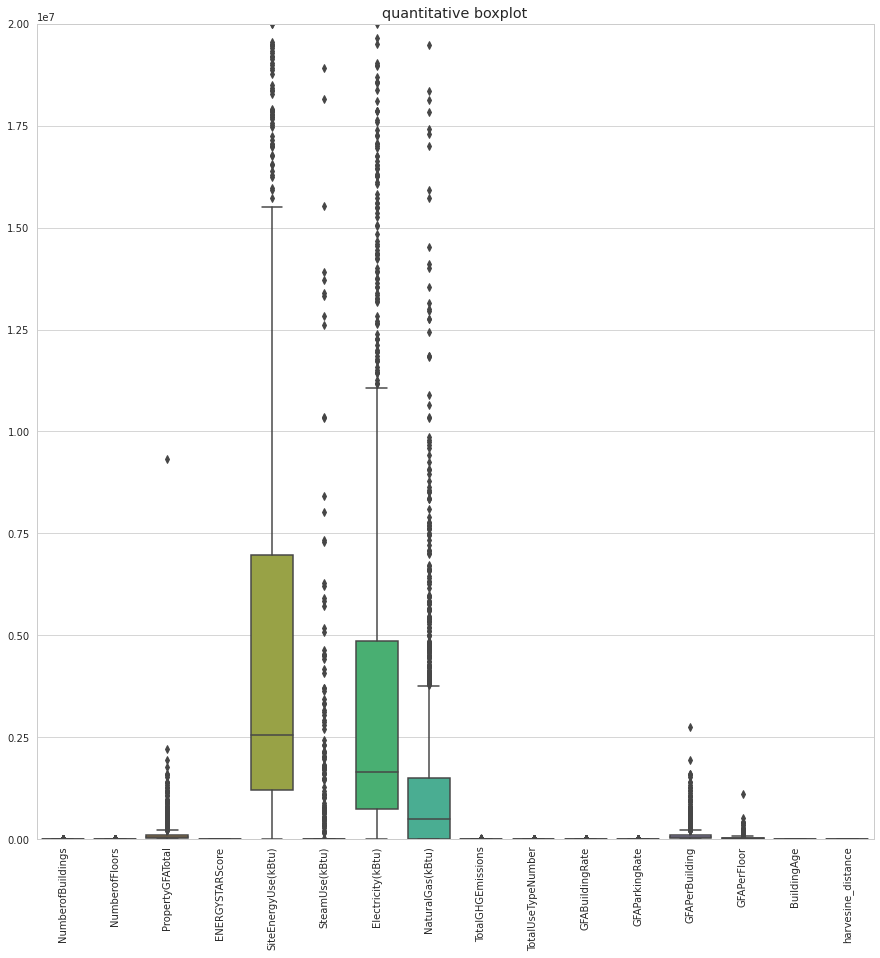

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

degrees = 90

fig = plt.figure(figsize=(15, 15))
ax = plt.axes()
plt.xticks(rotation=degrees)
ax.set_ylim([-1e1,2e7])
sns.boxplot(data=data[numerical_features]).set_title('quantitative boxplot');

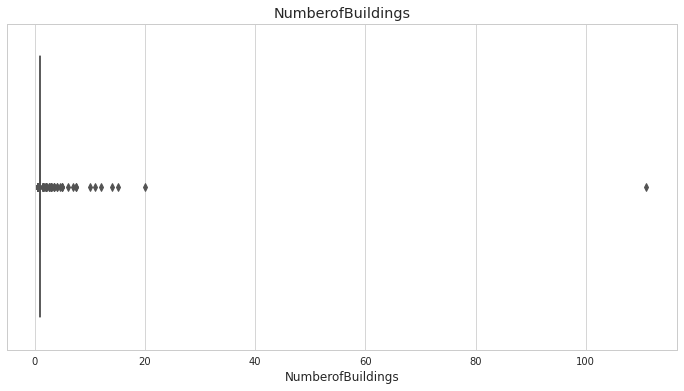

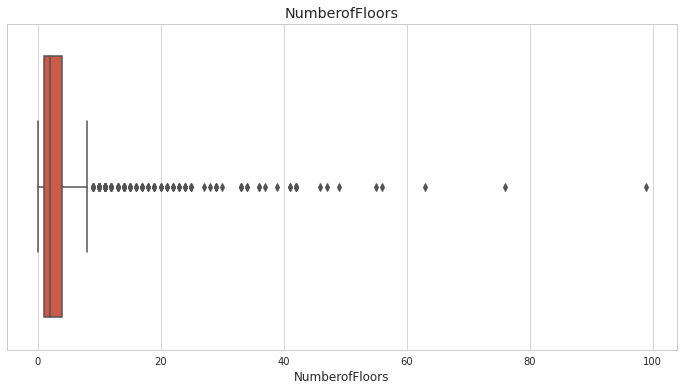

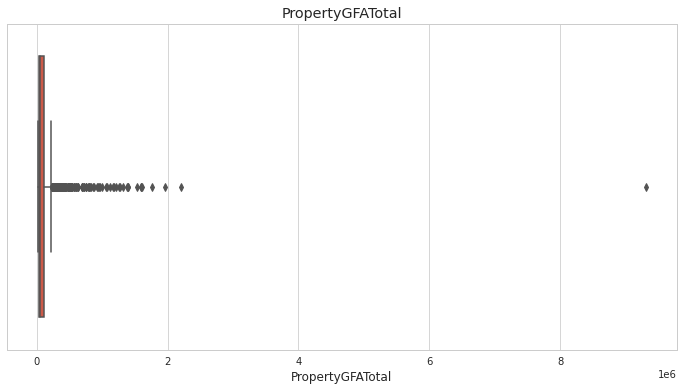

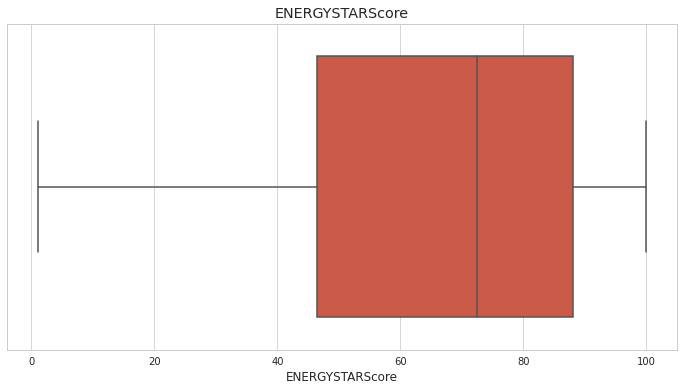

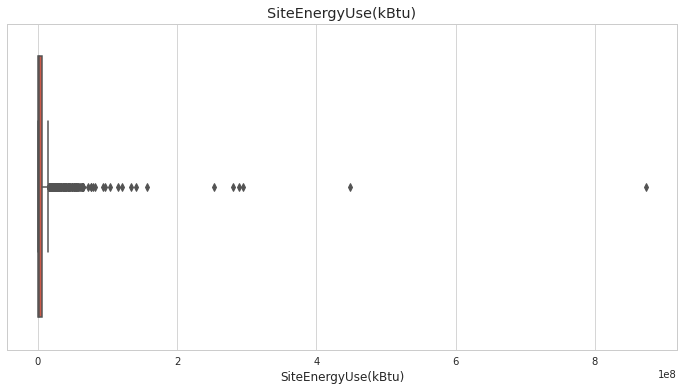

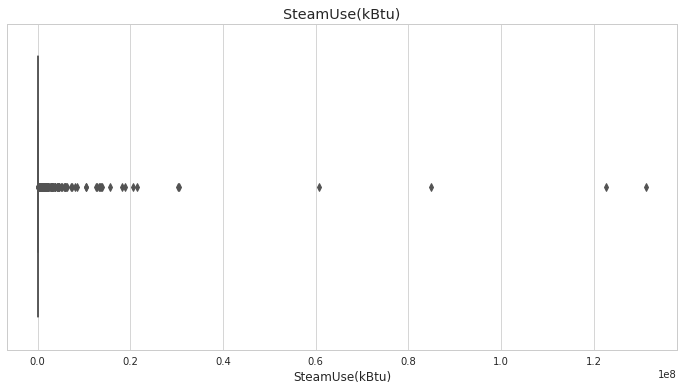

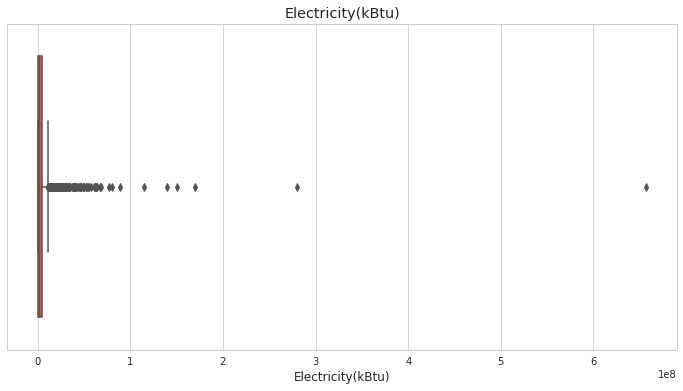

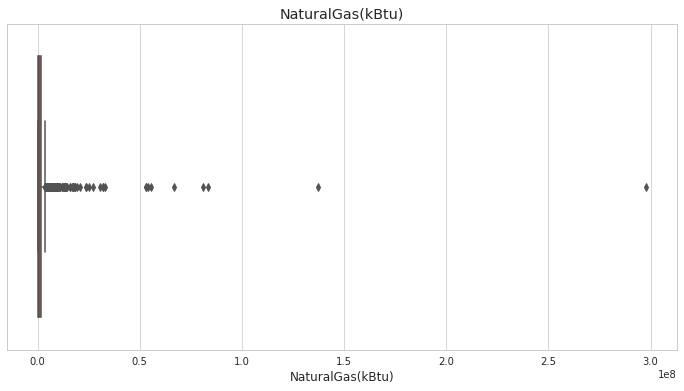

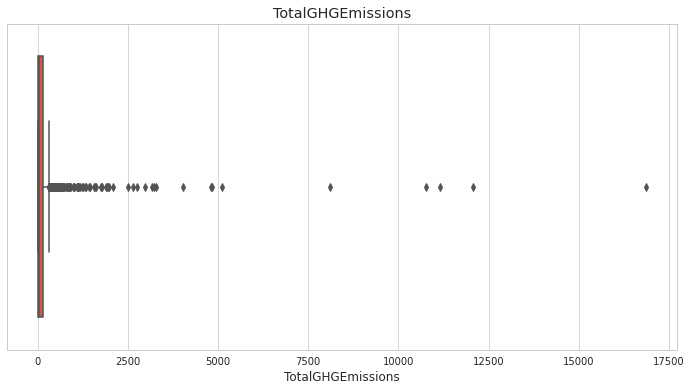

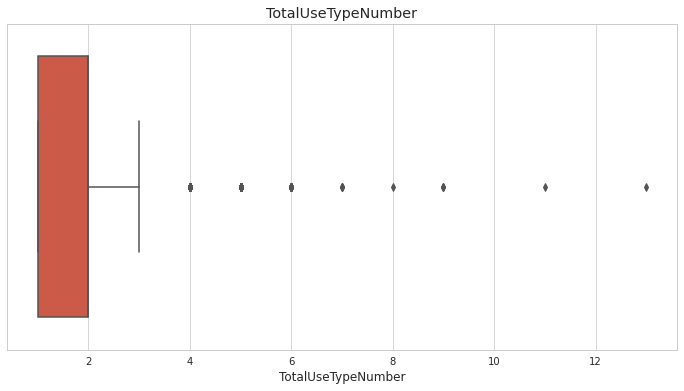

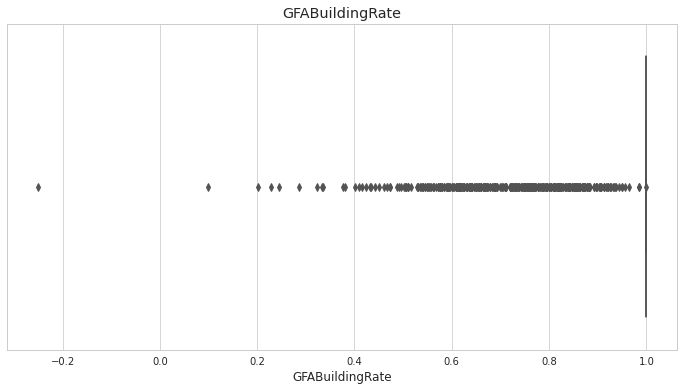

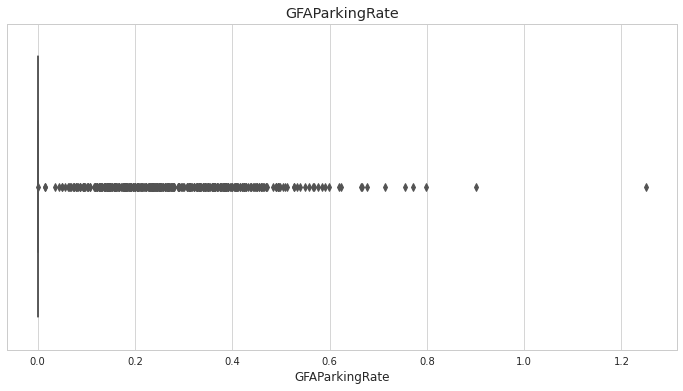

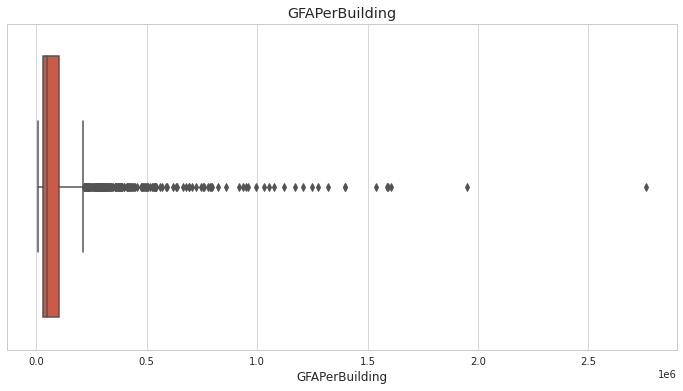

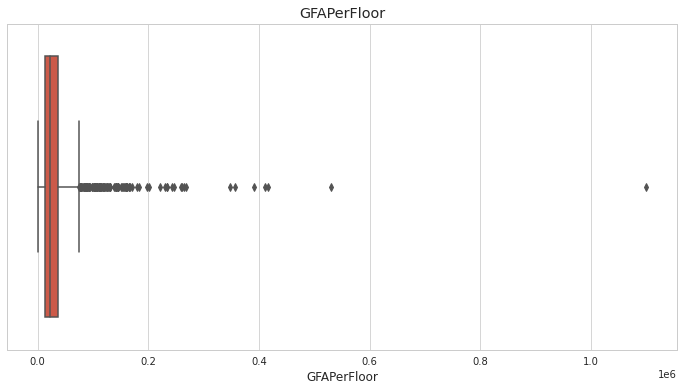

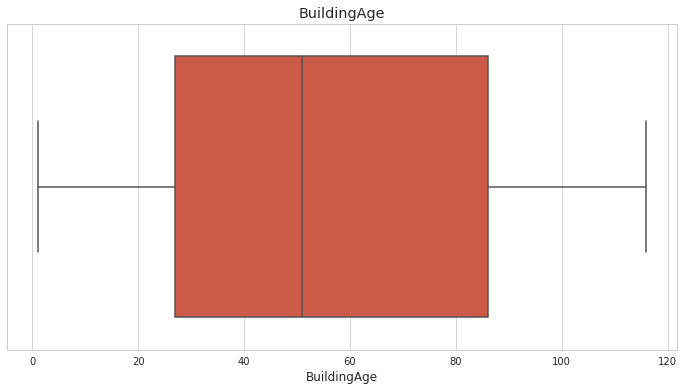

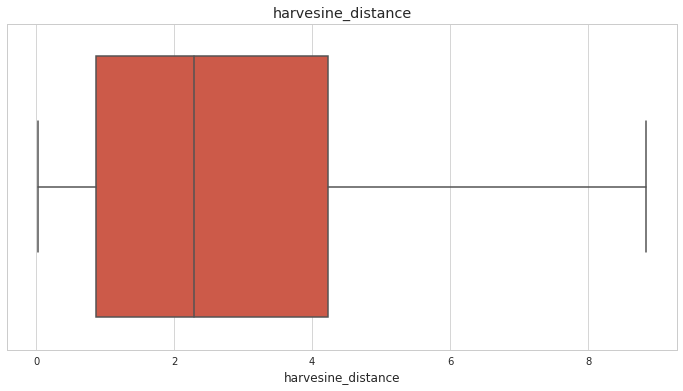

In [13]:
for feature in numerical_features:
    plt.figure(figsize=(12,6));
    sns.boxplot(x=data[feature]).set_title(feature);

### Comme nous l'avons remarqué dans le Notebook de nettoyage, les Campus sont très consommateurs en energie. Aprés avoir vérifier la distribution des consommations en fonction des surfaces totales au sol par catégorie de bâtiment. D'éventuels valeurs hors-normes pourraient poser des problèmes pour les modélisations.
### Un bâtiment de type campus est très supérieur aux autres données. Il ne s'agit sans doute pas d'une valeur abérrante mais d'une valeur atypique qui est très isolée. Nous allons ici la supprimer de nos données sources.

In [14]:
data[data['SiteEnergyUse(kBtu)']>2*10**7]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,LargestPropertyUseType,NumberofBuildings,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance
6,675,2015,NonResidential,Medical Office,NINTH & JEFFERSON BLDG - HARBORVIEW,908 JEFFERSON ST,98104.0,EAST,Medical Office,1.0,...,33557492.0,0.0,1891.470,2,0.42459,0.57541,434475.000,28965.000,7,0.405103
28,49859,2015,Campus,Other,AMGEN INC. MASTER CAMPUS,1201 AMGEN CT W,98119.0,MAGNOLIA / QUEEN ANNE,Other,7.0,...,76742000.0,80867644.0,4829.860,1,0.53495,0.46505,115502.857,202130.000,13,2.477926
31,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,DOWNTOWN,Hotel,1.0,...,49644549.5,2601850.0,2075.380,1,0.89744,0.10256,959050.000,23391.463,47,0.602378
39,16,2016,NonResidential,Hotel,5679-W Seattle,1112 Fourth Avenue,98101.0,DOWNTOWN,Hotel,1.0,...,18570885.5,3045700.0,732.185,1,0.81643,0.18357,333176.000,13327.040,18,0.083008
41,18,2016,NonResidential,Hotel,Crowne Plaza Hotel Seattle,1113 6th Ave,98101.0,DOWNTOWN,Hotel,1.0,...,13997544.5,4036860.0,661.980,2,0.81769,0.18231,315952.000,9574.303,36,0.130499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,49926,2016,NonResidential,University,SCCC MAIN BROADWAY/EDISON,1701 BROADWAY,98122.0,EAST,College/University,1.0,...,21773873.5,1516044.5,1267.060,1,1.00000,0.00000,428347.000,142782.333,91,0.913485
1651,49940,2016,NonResidential,Hospital,Virginia Mason Medical Center - 2149,925 Seneca St.,98101.0,EAST,Hospital (General Medical & Surgical),1.0,...,60532785.0,0.0,5112.460,1,1.00000,0.00000,374466.000,46808.250,96,0.324118
1656,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,98105.0,NORTHEAST,College/University,111.0,...,657074389.0,0.0,11140.560,1,1.00000,0.00000,83965.369,0.000,116,3.612662
1659,49972,2016,NonResidential,University,Computer Science and Electrical Engineering,3785 E Stevens Way NE,98195.0,NORTHEAST,College/University,1.0,...,28614613.0,0.0,199.480,1,1.00000,0.00000,203030.000,33838.333,18,3.486118


In [15]:
data.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,LargestPropertyUseType,NumberofBuildings,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance
0,325,2015,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,98101.0,DOWNTOWN,Unknown,1.0,...,9899135.0,0.0,69.01,1,1.00000,0.00000,111077.0,27769.250,26,0.439292
1,400,2015,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,98101.0,DOWNTOWN,Office,1.0,...,6488262.0,37893.0,47.24,1,0.73651,0.26349,98370.0,16395.000,109,0.236408
2,442,2015,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,98109.0,LAKE UNION,Office,1.0,...,16760914.0,0.0,116.84,5,0.80466,0.19534,193788.0,48447.000,68,1.171413
3,499,2015,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,98144.0,GREATER DUWAMISH,Office,1.0,...,2234200.0,2242889.0,134.69,2,0.72049,0.27951,76598.0,25532.667,7,2.924194
4,559,2015,NonResidential,Large Office,YALE & THOMAS,325 EASTLAKE AVE E,98109.0,LAKE UNION,Office,1.0,...,9657951.0,3004906.0,226.92,2,1.00000,0.00000,186971.0,46742.750,34,1.044201


In [16]:
data = data[data['SiteEnergyUse(kBtu)']<2*10**7]

###  Maintenant separons nos variables numériques des variables catégorielles

In [17]:
numerical_features = data.select_dtypes(include=['int64','float64'])
categorical_features = data.select_dtypes(exclude=['int64','float64']) 

In [18]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562 entries, 0 to 1696
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OSEBuildingID        1562 non-null   int64  
 1   DataYear             1562 non-null   int64  
 2   ZipCode              1546 non-null   float64
 3   NumberofBuildings    1562 non-null   float64
 4   NumberofFloors       1562 non-null   float64
 5   PropertyGFATotal     1562 non-null   float64
 6   ENERGYSTARScore      1072 non-null   float64
 7   SiteEnergyUse(kBtu)  1562 non-null   float64
 8   SteamUse(kBtu)       1562 non-null   float64
 9   Electricity(kBtu)    1562 non-null   float64
 10  NaturalGas(kBtu)     1562 non-null   float64
 11  TotalGHGEmissions    1562 non-null   float64
 12  TotalUseTypeNumber   1562 non-null   int64  
 13  GFABuildingRate      1562 non-null   float64
 14  GFAParkingRate       1562 non-null   float64
 15  GFAPerBuilding       1562 non-null   f

### Le but de notre demarche est de supprimer le recours au relevés qui reviennent chérs et de s'en passer pour les années à venir. Nous allons donc exclure toutes les données de relève de notre dataset.Quant à l'ENERGYSTARScore nous allons l'exclure car il est insuffisament fourni et voir seseffets sur les predictions à la fin.

In [19]:
energystar_score = numerical_features['ENERGYSTARScore']
numerical_features = numerical_features.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)','ENERGYSTARScore'], axis=1)

## Nous pouvons nous passer des variables d'identifications,ainsi que l'année des données qui n'apportent rien aux prédictions

In [20]:
['OSEBuildingID','ZipCode']


numerical_features = numerical_features.drop(['OSEBuildingID','ZipCode'], axis=1)

## Regardons maintenant les variables categorielles

In [21]:
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562 entries, 0 to 1696
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   BuildingType            1562 non-null   object
 1   PrimaryPropertyType     1562 non-null   object
 2   PropertyName            1562 non-null   object
 3   Address                 1562 non-null   object
 4   Neighborhood            1562 non-null   object
 5   LargestPropertyUseType  1562 non-null   object
dtypes: object(6)
memory usage: 85.4+ KB


### Supprimons les variables d'identifications qui n'apportent rien aux prédictions

In [22]:
categorical_features = categorical_features.drop( ['PropertyName', 'Address'],axis=1 )

### 1.1. Encodage et standardisation

#### Pour les données catégorielles, nous allons devoir encoder les valeurs. 

In [23]:
categorical_features.nunique()

BuildingType               5
PrimaryPropertyType       23
Neighborhood              19
LargestPropertyUseType    55
dtype: int64

### Pour ces variables, nous utiliserons la méthode TargetEncoder de la librairie Category_Encoders que nous intégrerons dans un pipeline Sklearn.
### Cet encodeur Ggoupe les données par chaque catégorie et compte de nombre d'occurrences de chaque cible et Calcul de la probabilité que chaque cible se produise pour chaque groupe spécifique.

In [24]:
list(numerical_features.columns)

['DataYear',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'BuildingAge',
 'harvesine_distance']

### Nous réaliserons un centrage-réduction via la méthode StandardScaler de Scikit-Learn.

In [25]:
data_mix = pd.concat([categorical_features, numerical_features], axis=1)
data_mix

,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,DataYear,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,harvesine_distance
0,NonResidential,Retail Store,DOWNTOWN,Unknown,2015,1.0,4.0,111077.0,9.898724e+06,69.01,1,1.00000,0.00000,111077.0,27769.250,26,0.439292
1,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,Office,2015,1.0,6.0,98370.0,6.525887e+06,47.24,1,0.73651,0.26349,98370.0,16395.000,109,0.236408
2,NonResidential,Large Office,LAKE UNION,Office,2015,1.0,4.0,193788.0,1.676022e+07,116.84,5,0.80466,0.19534,193788.0,48447.000,68,1.171413
3,NonResidential,Small- and Mid-Sized Office,GREATER DUWAMISH,Office,2015,1.0,3.0,76598.0,4.476997e+06,134.69,2,0.72049,0.27951,76598.0,25532.667,7,2.924194
4,NonResidential,Large Office,LAKE UNION,Office,2015,1.0,4.0,186971.0,1.266246e+07,226.92,2,1.00000,0.00000,186971.0,46742.750,34,1.044201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,Nonresidential COS,Office,GREATER DUWAMISH,Office,2016,1.0,1.0,12294.0,8.497457e+05,20.94,1,1.00000,0.00000,12294.0,12294.000,26,2.856620
1693,Nonresidential COS,Other,DOWNTOWN,Other - Recreation,2016,1.0,1.0,16000.0,9.502762e+05,32.17,1,1.00000,0.00000,16000.0,16000.000,12,0.811312
1694,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,Other - Recreation,2016,1.0,1.0,13157.0,5.765898e+06,223.54,3,1.00000,0.00000,13157.0,13157.000,42,2.407156
1695,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,Other - Recreation,2016,1.0,1.0,14101.0,7.194712e+05,22.11,5,1.00000,0.00000,14101.0,14101.000,27,5.389475


In [26]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType']
target_transformer = TargetEncoder()

numeric_features = ['harvesine_distance','NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','BuildingAge','TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer = RobustScaler(with_centering=True,with_scaling=True,quantile_range=(25.0, 75.0),
                                          copy=True,)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

In [27]:
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
        
    ------
    Code from :
        https://johaupt.github.io/
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        feature_names.extend(get_names(trans))
    
    return feature_names


### 1.2. Préparation des jeux d'entrainement et de test

In [28]:
data_mix = data_mix.replace([-np.inf,np.inf], np.nan)

In [29]:
data_mix = data_mix .dropna(how="all")

In [30]:
 data_mix.dropna(inplace = True)

In [31]:
import numpy as np
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

X = data_mix.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = data_mix[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(X , Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1249 lignes,
Test: 313 lignes.



#### Concernant nos variables à prédire, nous allons regarder l'impact du passage à l'échelle logarithmique sur les distribution :

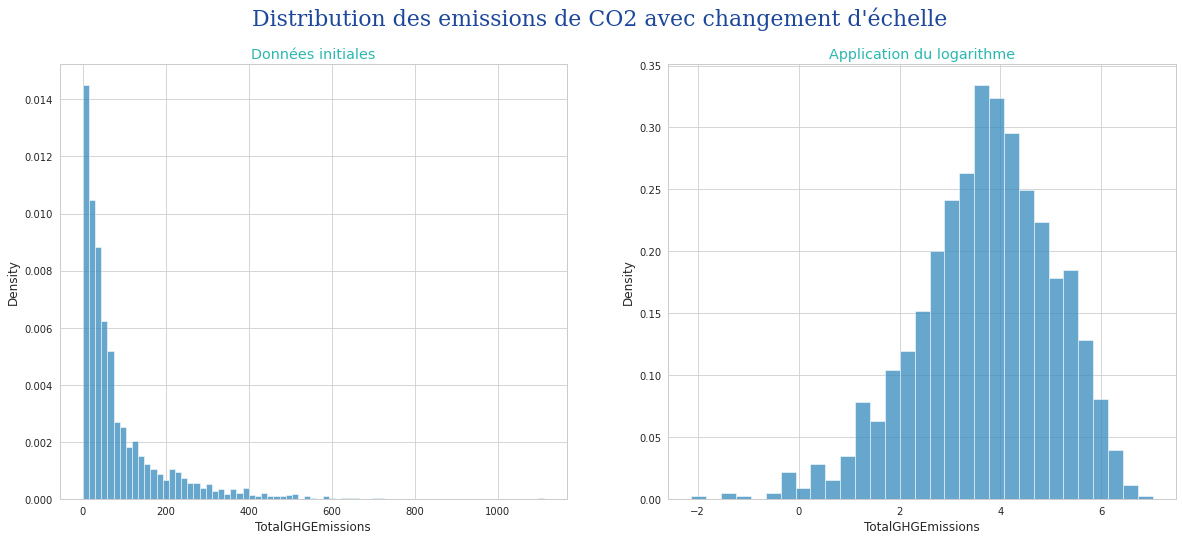

In [32]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

#### En passant les données à l'échelle logarithmique, nous obtenons une distribution normale des données à prédire. Nous allons donc appliquer cette transformation dans notre pipeline grâce à la fonction TransformedTargetRegressor de la librairie Sklearn.

### La fonction inverse (exp) sera donc passée dans les prédictions.

# 2. Modèle Baseline : Régression linéaire multivariée

### A présent, nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliorent les prédictions. Pour cette baseline, nous utiliserons une régression linéaire multivariée.

In [33]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(display='diagram')


param_mlr = {"regressor__fit_intercept": [True, False],
             "regressor__normalize": [True, False]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearRegression(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

### Nous allons calculer 2 principales métriques pour évaluer nos modèles :

### MAE : Mean Absolute Error.
### R² : Coeficient de détermination, carré du coefiscient de corrélation linéaire

In [34]:
#Retour des meilleurs scores NMAE et R2
#Stockage du dataframe de resultats du modèle
def model_scores(pip,step):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_) \
                    .sort_values('rank_test_neg_mean_absolute_error')
    best_nmae = pip.named_steps[step].best_score_
    best_r2 = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2'])
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*X_train.shape[0]),2)
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(best_nmae,3), round(best_r2,3), best_params, training_time))
    return df_results


### On affiche les scores de la GridSearch avec validation croisée pour la variable TotalGHGEmissions :

In [35]:
#Entrainement sur les 2 variables à expliquer :
GHG_mlr_model = mlr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_mlr_results = model_scores(GHG_mlr_model, 'grid_search_mlr')

Meilleur score MAE : -56.332
Meilleur Score R2 : -2.662
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': True}
Temps moyen d'entrainement : 19.73s


### et les scores pour la variable SiteEnergyUse(kBtu) :

In [36]:
SEU_mlr_model = mlr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_mlr_results = model_scores(SEU_mlr_model, 'grid_search_mlr')

Meilleur score MAE : -2101894.503
Meilleur Score R2 : -1.304
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': True}
Temps moyen d'entrainement : 2.79s


#### Tous les résultats des GridSearchCV sont stockés dans un DataFrame pour chaque variable à prédire :

In [37]:
GHG_mlr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,param_regressor__normalize,params,split0_test_r2,split1_test_r2,split2_test_r2,...,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,0.056774,0.071029,0.001465,0.000388,True,True,"{'regressor__fit_intercept': True, 'regressor_...",0.262442,-2.038019,-1.253589,...,-56.332428,7.734904,1,-50.018813,-49.363422,-48.196975,-50.504643,-49.493085,-49.515388,0.773804
1,0.002290,0.000289,0.001163,0.000054,True,False,"{'regressor__fit_intercept': True, 'regressor_...",0.262442,-2.038019,-1.253589,...,-56.332428,7.734904,1,-50.018813,-49.363422,-48.196975,-50.504643,-49.493085,-49.515388,0.773804
2,0.002024,0.000277,0.001183,0.000254,False,True,"{'regressor__fit_intercept': False, 'regressor...",0.272095,-1.789907,-2.774873,...,-56.961568,7.995902,3,-50.300251,-49.640730,-48.481791,-50.705566,-49.996948,-49.825057,0.757495
3,0.002086,0.000185,0.001202,0.000232,False,False,"{'regressor__fit_intercept': False, 'regressor...",0.272095,-1.789907,-2.774873,...,-56.961568,7.995902,3,-50.300251,-49.640730,-48.481791,-50.705566,-49.996948,-49.825057,0.757495


In [38]:
SEU_mlr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('numeric', RobustScaler(),
                                                  ['harvesine_distance',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNumber',
                                                   'GFABuildingRate',
                                                   'GFAParkingRate',
                                                   'GFAPe...
                                                   'GFAPerFloor'])])),
                ('grid_search_mlr',
                 GridSearchCV(cv=5,
                              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=LinearRegression()),
                              n_jobs=-1,
                              param_grid={'regressor__fit_intercept': [True,
                                                                       False],
                                          'regressor__normalize': [True,
                                                                   False]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

#### Nous avons à présent nos métriques de départ obtenues avec notre modèle de régression linéaire multivarié servant de baseline. Nous allons réaliser nos premières modélisations en utilisant des modèles linéaires

# 3. Modèle linéaires : ElasticNet et SVR

In [39]:
from sklearn.linear_model import ElasticNet

param_eNet = {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.logspace(-4, 0, num=5),
              "regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=ElasticNet(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])


In [40]:
GHG_eNet_model = eNet_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_eNet_results = model_scores(GHG_eNet_model, 'grid_search_enet')

Meilleur score MAE : -48.651
Meilleur Score R2 : 0.248
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 0.1, 'regressor__max_iter': 100}
Temps moyen d'entrainement : 5.75s


In [41]:
SEU_eNet_model = eNet_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_eNet_results = model_scores(SEU_eNet_model, 'grid_search_enet')

Meilleur score MAE : -1824501.952
Meilleur Score R2 : 0.464
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 0.2, 'regressor__max_iter': 10}
Temps moyen d'entrainement : 6.57s


### Suite à cette première modélisation par ElasticNet, les métriques ne se sont que légérement améliorées pour les prédictions de la consommation d'énergie et des émissions de CO2. Nous allons à présent tester un second modèle linéaire : SVR.

# 3.2. Modèle Support Vector Regression (SVR)

In [42]:
from sklearn.svm import LinearSVR

param_svr = {'regressor__C' : np.logspace(-4, 0, 5),
             'regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'regressor__max_iter': [10, 100, 1000]}

svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearSVR(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_svr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [43]:
GHG_svr_model = svr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_svr_results = model_scores(GHG_svr_model, 'grid_search_svr')

Meilleur score MAE : -48.281
Meilleur Score R2 : 0.295
Meilleurs paramètres : {'regressor__C': 0.001, 'regressor__epsilon': 0, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 1000}
Temps moyen d'entrainement : 40.22s


In [44]:
SEU_svr_model = svr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_svr_results = model_scores(SEU_svr_model, 'grid_search_svr')

Meilleur score MAE : -3922398.047
Meilleur Score R2 : -0.884
Meilleurs paramètres : {'regressor__C': 0.0001, 'regressor__epsilon': 0, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 10}
Temps moyen d'entrainement : 37.46s


### Sur ce modèle SVR linéaire, les métriques sont encore légérement améliorées pour les 2 variables à prédire comparées au modèle ElasticNet.
### Nous allons à présent nous pencher sur des modèles non-linéaires.


# 4. Modèle non-linéaires : XGBoost et RandomForestRegressor

### 4.1. Modèle RandomForestRegressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

param_rfr = {'regressor__max_features' : ['sqrt', 'log2'],
             'regressor__max_depth': [5, 15, 25, 50],
             'regressor__min_samples_split': [2, 5, 10],
             'regressor__bootstrap' : [True, False],
             'regressor__min_samples_leaf': [1,2,5,10]}

rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])


In [46]:
GHG_rfr_model = rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_rfr_results = model_scores(GHG_rfr_model, 'grid_search_rfr')

Meilleur score MAE : -45.234
Meilleur Score R2 : 0.369
Meilleurs paramètres : {'regressor__bootstrap': True, 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 451.65s


In [47]:
SEU_rfr_model = rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_rfr_results = model_scores(SEU_rfr_model, 'grid_search_rfr')


Meilleur score MAE : -1484467.27
Meilleur Score R2 : 0.642
Meilleurs paramètres : {'regressor__bootstrap': True, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}
Temps moyen d'entrainement : 448.85s


### 4.2. Modèle XGBoost (eXtreme Gradient Boosting)

In [48]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [ 0.01,0.001,0.1,0.2,0.3],
             'regressor__gamma': [0,0.01,0.001,0.1,0.25,0.5],
             'regressor__max_depth': [3,6,9,12,15],
             'regressor__min_child_weight' : [ 1,2,3,5,7,9],
             'regressor__n_estimators': [ 50,100,125,150]}

xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_xgb', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(tree_method='gpu_hist'), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [49]:
GHG_xgb_model = xgb_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_xgb_results = model_scores(GHG_xgb_model, 'grid_search_xgb')

Meilleur score MAE : -45.18
Meilleur Score R2 : 0.393
Meilleurs paramètres : {'regressor__n_estimators': 100, 'regressor__min_child_weight': 2, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.1}
Temps moyen d'entrainement : 1532.79s


In [50]:
SEU_xgb_model = xgb_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_xgb_results = model_scores(SEU_xgb_model, 'grid_search_xgb')

Meilleur score MAE : -1425508.519
Meilleur Score R2 : 0.679
Meilleurs paramètres : {'regressor__n_estimators': 150, 'regressor__min_child_weight': 9, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.25}
Temps moyen d'entrainement : 642.21s


### Le modèle XGBoost non-linéaire a des niveaux de performances de prédiction sur les 2 variables quasi similaire au modèle RandomForestRegressor mais nous avons dû utiliser le GPU pour accélerer le temps de calcul.

# 5. Sélection des meilleurs modèles

### Sur les 4 modèles testés,les modèles linéaires retournent de moins bonnes métriques en général. Si nous prenons en considération le score MAE, qui aura du sens sur les modèles linéaires et non-linéaires, les algorithmes XGBoost et RandomForestRegressor offrent des performances à peu près similaires pour la qualité des prédictions mais les temps de calculs sont meilleurs sur le modèle RandomForestRegressor.

### Nous allons donc regarder de plus près les résultats obtenus sur nos 2 variables à prédire avec les différents modèles :

### 5.1. Modèle de prédiction des émissions de CO2

In [51]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']
GHG_compare_metrics = pd.concat([pd.DataFrame(GHG_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(GHG_xgb_results[metrics].mean(), columns=['XGBoost']),
           pd.DataFrame(GHG_svr_results[metrics].mean(), columns=['LinearSVR']),
           pd.DataFrame(GHG_eNet_results[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(GHG_mlr_results[metrics].mean(), columns=['LinearRegression'])
          ], axis=1)
GHG_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForest','XGBoost',
                                            'LinearSVR','ElasticNet',
                                            'LinearRegression'])
for m in metrics:
    GHG_final_metrics_compare[m] = GHG_compare_metrics.loc[m]

In [52]:
GHG_final_metrics_compare

,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
RandomForest,0.361611,0.015098,-46.645586,-32.970753
XGBoost,1.227214,0.080061,-59.232607,-45.503074
LinearSVR,0.032201,0.001754,-124.949049,-120.138293
ElasticNet,0.004602,0.001618,-52.157895,-49.516943
LinearRegression,0.015794,0.001254,-56.646998,-49.670223


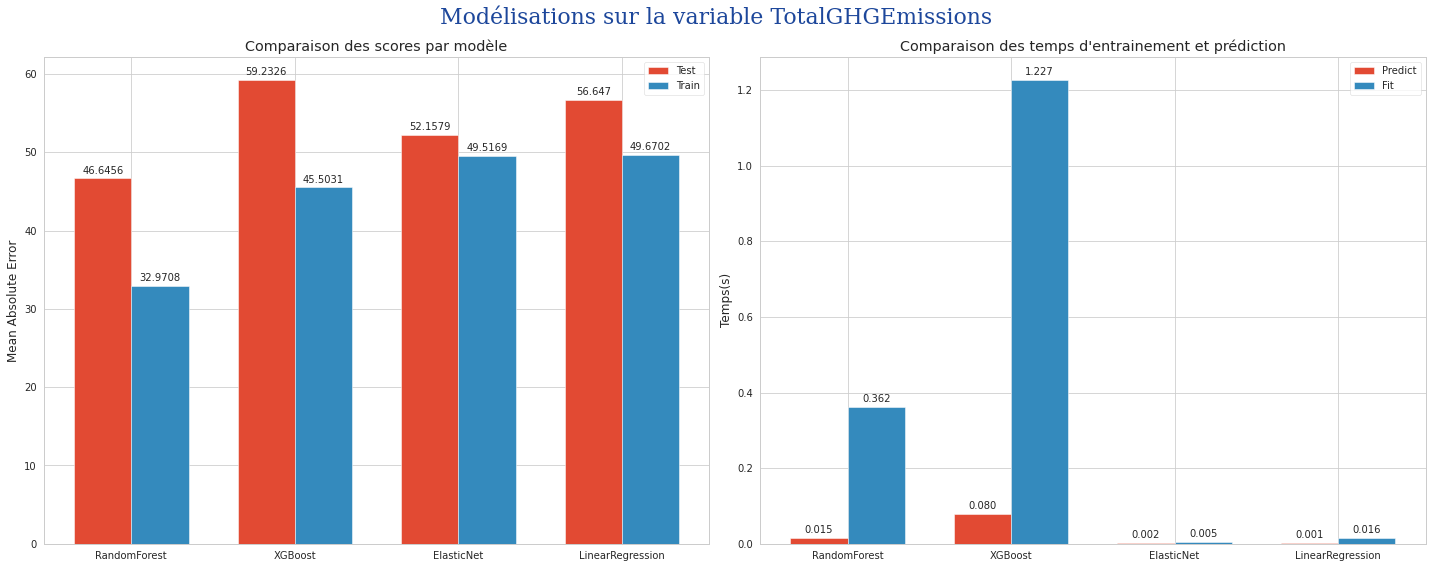

In [53]:
#On élimine le modèle SVR de cette représentation car hors normes
GHG_final_metrics_compare = GHG_final_metrics_compare[GHG_final_metrics_compare.index != 'LinearSVR']
x = np.arange(len(GHG_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*GHG_final_metrics_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*GHG_final_metrics_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(GHG_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, GHG_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, GHG_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(GHG_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable TotalGHGEmissions", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

### Avec la projection graphique ci-dessus, on constate que le modèle RandomForestRegressor offre le meilleur compromis score / temps. Il est en effet meilleur en terme de score MAE et également bien plus rapide que le modèle XGBoost.

### Le modéle retenu pour la modélisation de la variable TotalGHGEmissions est donc le modèle RandomForestRegressor. Nous allons à présent visualiser l'impact des hyperparamètres de la GridSearch :

In [54]:
#Fonction d'affichage des scores de GridSearch pour chacun des paramètres
def plot_search_results(grid, title): 
       
    ## Résultats de la GridSearch
    results = grid.cv_results_
    means_test = results['mean_test_neg_mean_absolute_error']
    stds_test = results['std_test_neg_mean_absolute_error']
    means_train = results['mean_train_neg_mean_absolute_error']
    stds_train = results['std_train_neg_mean_absolute_error']

    ## Index de valeurs par hyper-paramètre
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    
    ## Plot des résultats
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Scores par paramètres pour la variable {}'.format(title), 
                 fontdict=font_title, fontsize=22)
    fig.text(0.04, 0.5, 'NEG MEAN ABSOLUTE ERROR SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test', color="#2cb7b0")
        ax[i].errorbar(x, y_2, e_2, linestyle='--', marker='o', label='train', color="#337da4")
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    
    print("\nRappel des meilleurs paramètres :\n{}".format(grid.best_params_))

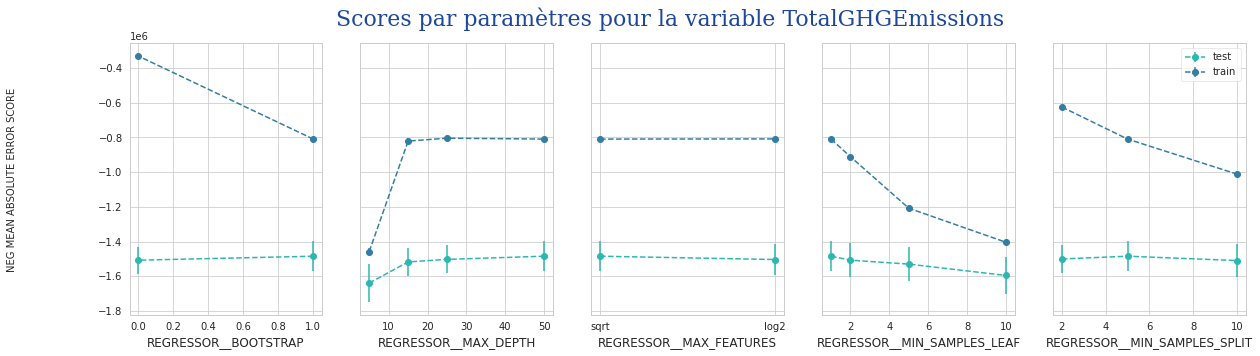


Rappel des meilleurs paramètres :
{'regressor__bootstrap': True, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}


In [55]:
plot_search_results(GHG_rfr_model.named_steps['grid_search_rfr'], title="TotalGHGEmissions")

### Après avoir testé les premiers paramètres, nous avons à présent défini notre modèle pour la prédiction des émissions de CO2. Regardons à présent l'importance des variables dans notre modèle de forêts aléatoires :

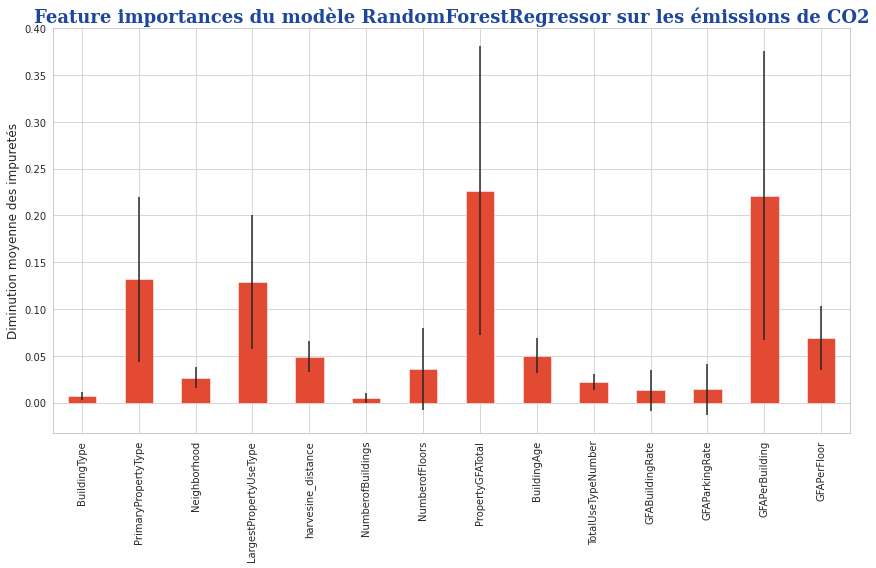

In [56]:
feature_importance = GHG_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
features_names = get_feature_names(GHG_rfr_model.named_steps['preprocessor'])
std = np.std([
    tree.feature_importances_ for tree in GHG_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur les émissions de CO2", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

#### Les surfaces (GFA) de la propriété et le type d'utilisation principale ont un poids plus important dans les décisions de notre modèle. En revanche, le type de bâtiment a un impact très limité. On remarque également que l'age du batiment ou encore son emplacement géographique n'ont pas un impact très important non plus.

### 5.2. Modèle de prédiction des consommations d'énergie

#### Cette fois encore, nous allons comparer les métriques obtenues sur les différents modèles :

In [57]:
SEU_compare_metrics = pd.concat([pd.DataFrame(SEU_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(SEU_xgb_results[metrics].mean(), columns=['XGBoost']),
           pd.DataFrame(SEU_svr_results[metrics].mean(), columns=['LinearSVR']),
           pd.DataFrame(SEU_eNet_results[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(SEU_mlr_results[metrics].mean(), columns=['LinearRegression'])
          ], axis=1)
SEU_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForest','XGBoost',
                                            'LinearSVR','ElasticNet',
                                            'LinearRegression'])
for m in metrics:
    SEU_final_metrics_compare[m] = SEU_compare_metrics.loc[m]
SEU_compare_metrics

,RandomForest,XGBoost,LinearSVR,ElasticNet,LinearRegression
mean_fit_time,3.593644e-01,5.141803e-01,2.998921e-02,5.257097e-03,2.235520e-03
mean_score_time,1.455227e-02,1.319802e-02,1.630036e-03,1.617508e-03,1.104307e-03
mean_test_neg_mean_absolute_error,-1.551329e+06,-2.317262e+06,-3.922398e+06,-2.059672e+06,-3.610186e+06
mean_train_neg_mean_absolute_error,-1.072747e+06,-1.852827e+06,-3.922501e+06,-1.943281e+06,-3.174687e+06


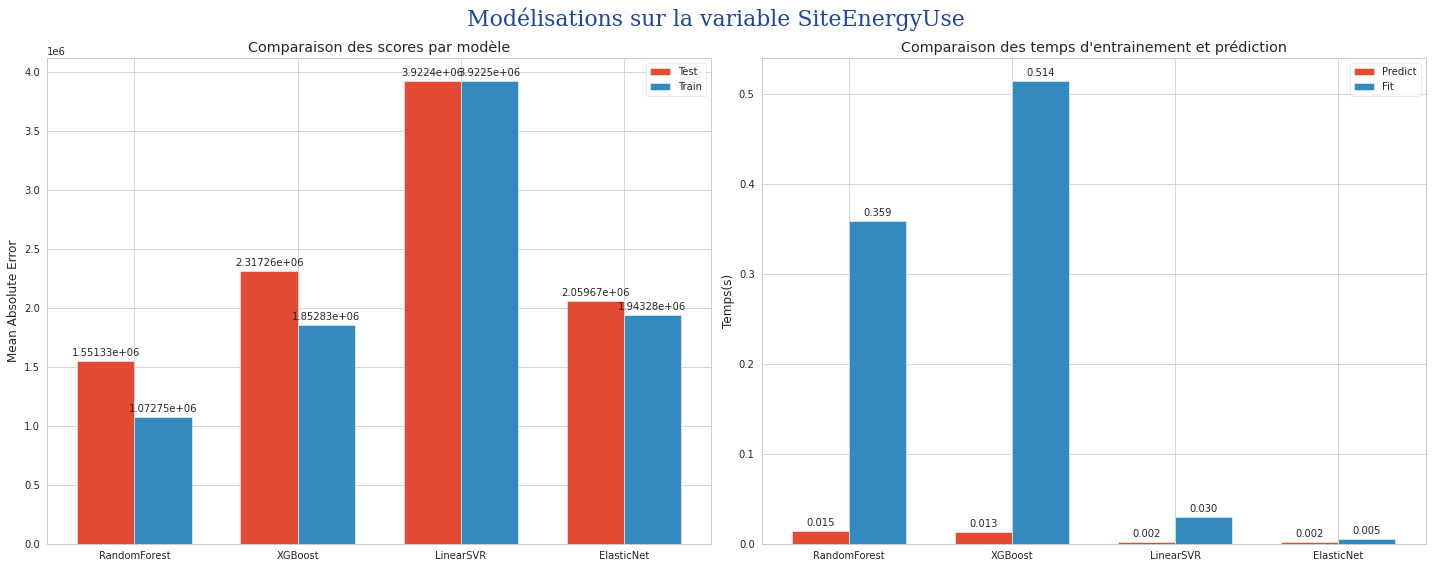

In [58]:
SEU_final_metrics_compare = SEU_final_metrics_compare[SEU_final_metrics_compare.index != 'LinearRegression']
x = np.arange(len(SEU_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*SEU_final_metrics_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*SEU_final_metrics_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(SEU_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, SEU_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, SEU_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(SEU_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable SiteEnergyUse", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()


### Pour la variable SiteEnergyUse, le modèle RandomForest offre à nouveau les meilleurs scores MAE et les meilleurs temps d'entrainement et de prédiction. Nous allons donc séléctionner le modèle RandomForestRegressor pour prédire la variable SiteEnergyUse.

### Regardons maintenant l'impact des hyperparamètres de la Grille de recherche :

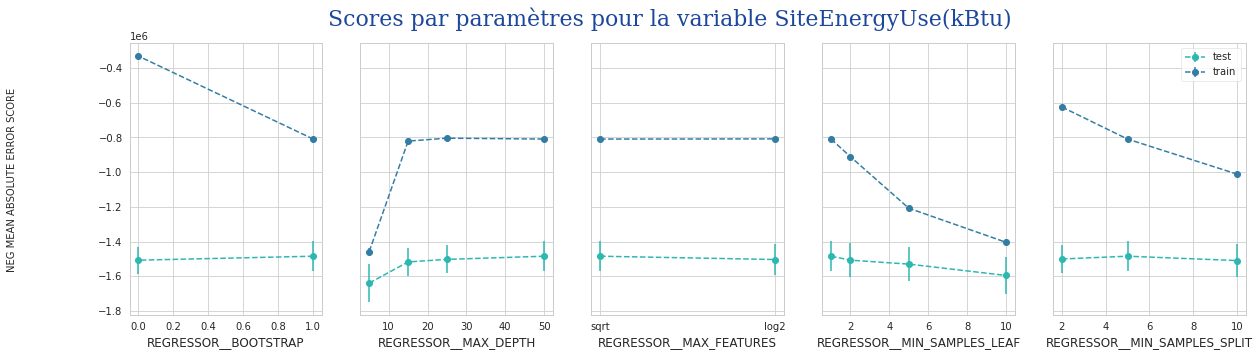


Rappel des meilleurs paramètres :
{'regressor__bootstrap': True, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}


In [59]:
plot_search_results(SEU_rfr_model.named_steps['grid_search_rfr'], title="SiteEnergyUse(kBtu)")

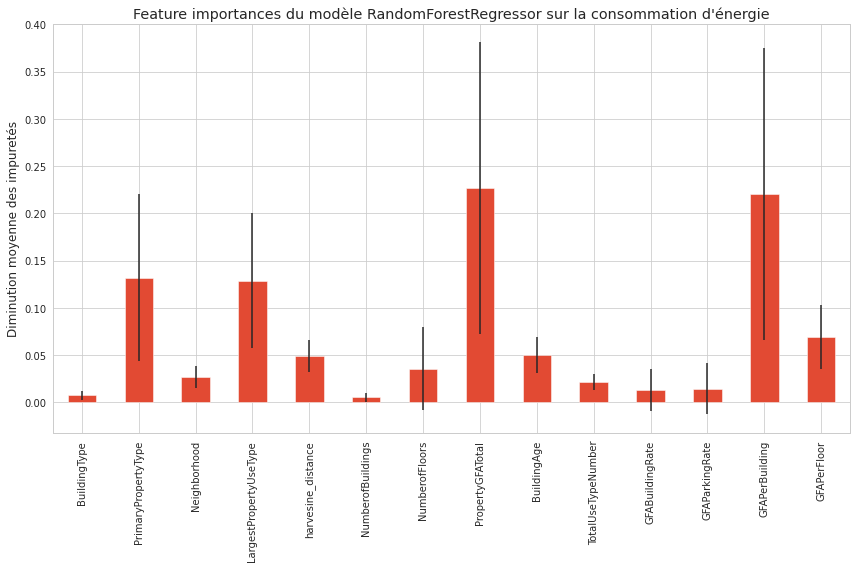

In [60]:
feature_importance = SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
features_names = get_feature_names(SEU_rfr_model.named_steps['preprocessor'])
std = np.std([
    tree.feature_importances_ for tree in SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur la consommation d'énergie")
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

### Pour les consommations d'énergie, la surface de la propriété à ici également une importance bien supérieure aux autres variables.

# 6. Test des modèles sélectionnés
### Nous allons à présent tester les modèles sélectionnés sur nos données test et vérifier leurs performances.

### 6.1. Prédiction des émissions de CO2

In [61]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "R²"], "Résultats":[mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [62]:
def plot_pred_true(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, color=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles")
    plt.ylabel("Valeurs prédites")
    plt.title("Valeurs prédites VS valeurs réélles | Variable {}".format(title), 
              fontdict=font_title, fontsize=18)
    plt.show()

In [63]:
#Modèle avec les meilleurs paramètres pour les émissions de CO2

import time
start_time = time.time()

GHG_pred = GHG_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.025 s.


In [64]:
#Calcul des métriques pour les émissions de CO2
GHGmetrics = metrics_model(Y_test['TotalGHGEmissions'],GHG_pred)
GHGmetrics

,Métrique,Résultats
0,MAE,3.397860e+06
1,R²,-1.210860e+09


### Les métriques sur le jeu de données de test sont très dégradées comparativement aux métriques obtenues avec la GridSearch avec le modèle de RandomForestRegressor. Nous allons vérifier la distribution des valaurs prédites en fonction des valeurs réélles :

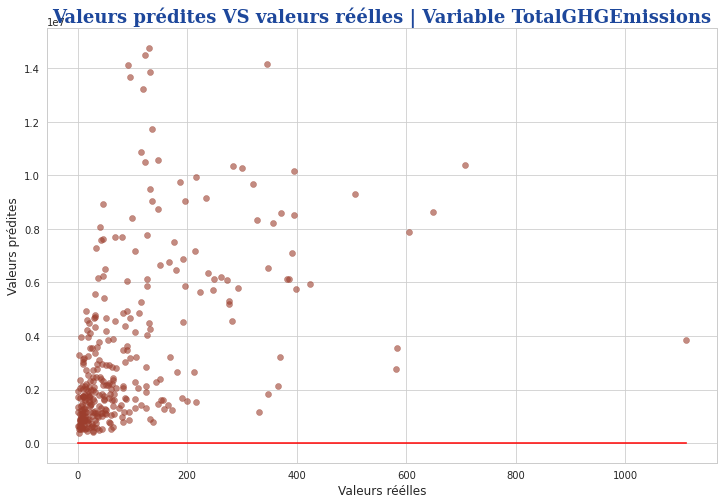

In [65]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['TotalGHGEmissions'],GHG_pred, color="#9C3E2D", title="TotalGHGEmissions")

### Les valeurs prédites sont très éloignées de la première bissectrice. En effet, le transformer log() / exp() de notre variable Y emplifie les erreurs lors de la transformation inverse.

### Nous allons regarder les scores obtenus sur les différents splits de la Cross-validation pour vérifier les écarts :

In [66]:
GHG_test_results = GHG_rfr_results[['split0_test_neg_mean_absolute_error',
                'split1_test_neg_mean_absolute_error',
                'split2_test_neg_mean_absolute_error',
                'split3_test_neg_mean_absolute_error',
                'split4_test_neg_mean_absolute_error',
                ]][GHG_rfr_results['rank_test_neg_mean_absolute_error']==1].values
GHG_train_results = GHG_rfr_results[['split0_train_neg_mean_absolute_error',
                'split1_train_neg_mean_absolute_error',
                'split2_train_neg_mean_absolute_error',
                'split3_train_neg_mean_absolute_error',
                'split4_train_neg_mean_absolute_error',
                ]][GHG_rfr_results['rank_test_neg_mean_absolute_error']==1].values

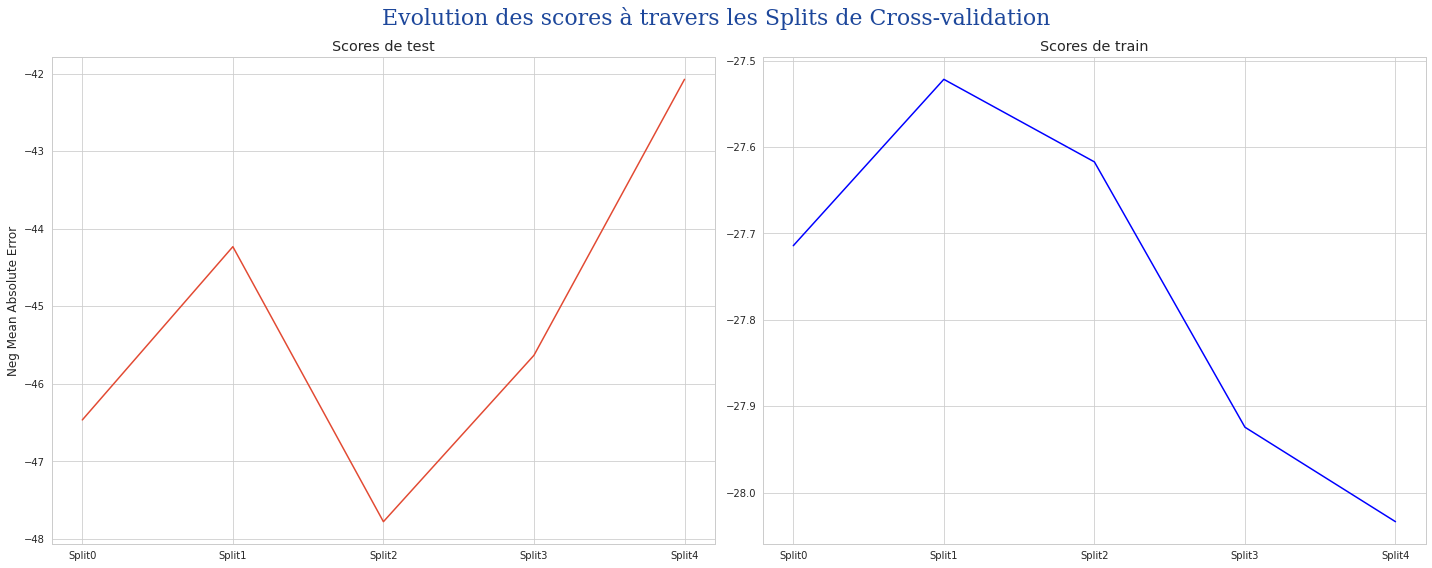

In [67]:
x = np.arange(0,5,1)
fig, ax = plt.subplots(1,2, figsize=(20,8), sharey=False, sharex=False)
ax[0].plot(range(0,5), GHG_test_results.reshape(-1))
ax[0].set_xticks(x)
ax[0].set_xticklabels(["Split"+str(n) for n in range(0,5)])
ax[0].set_ylabel('Neg Mean Absolute Error')
ax[0].set_title('Scores de test')

ax[1].plot(range(0,5), GHG_train_results.reshape(-1), color='b')
ax[1].set_xticks(x)
ax[1].set_xticklabels(["Split"+str(n) for n in range(0,5)])
ax[1].set_title('Scores de train')

plt.suptitle("Evolution des scores à travers les Splits de Cross-validation", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

### On voit ici que les scores des différents splits de cross-validation, pour les meilleurs paramètres obtenus, évoluent correctement lors de l'entrainement et des test, tout en restant dans la même échelle.

### Les écarts et mauvais résultats obtenus dépendent donc du faible nombre de données qui impactent le Train_Test_Split initial. Le modèle est correctement entrainé mais n'obtient pas de bon résultats sur le jeu de test (pas d'overfiting constaté dans les entrainements).

### 6.2. Prédiction des consommations d'énergie

In [68]:
start_time = time.time()

SEU_pred = SEU_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.024 s.


In [69]:
#Calcul des métriques pour les émissions de CO2
SEUmetrics = metrics_model(Y_test['SiteEnergyUse(kBtu)'],SEU_pred)
SEUmetrics

,Métrique,Résultats
0,MAE,1.822608e+06
1,R²,5.743000e-01


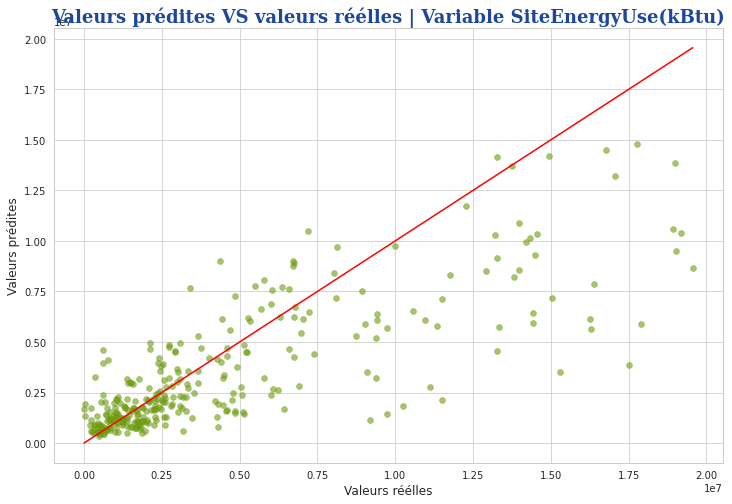

In [70]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['SiteEnergyUse(kBtu)'],SEU_pred, color="#6D9C0E", title="SiteEnergyUse(kBtu)")

### Ici encore, le même problème que pour la variable TotalGHG se pose. Le modèle est performant en entrainement mais ne parveint pas à généraliser sur le jeu de test.

### Nous allons regarder les écarts de prédiction en fonction du type de bâtiment pour vérifier si des écarts sont plus importants dans certaines catégories :

In [71]:
final_SEU_test = pd.concat([X_test,Y_test],axis=1)
final_SEU_test['SEU_pred'] = SEU_pred
compare_final_SEU_test = final_SEU_test = final_SEU_test.groupby(by='BuildingType').mean()

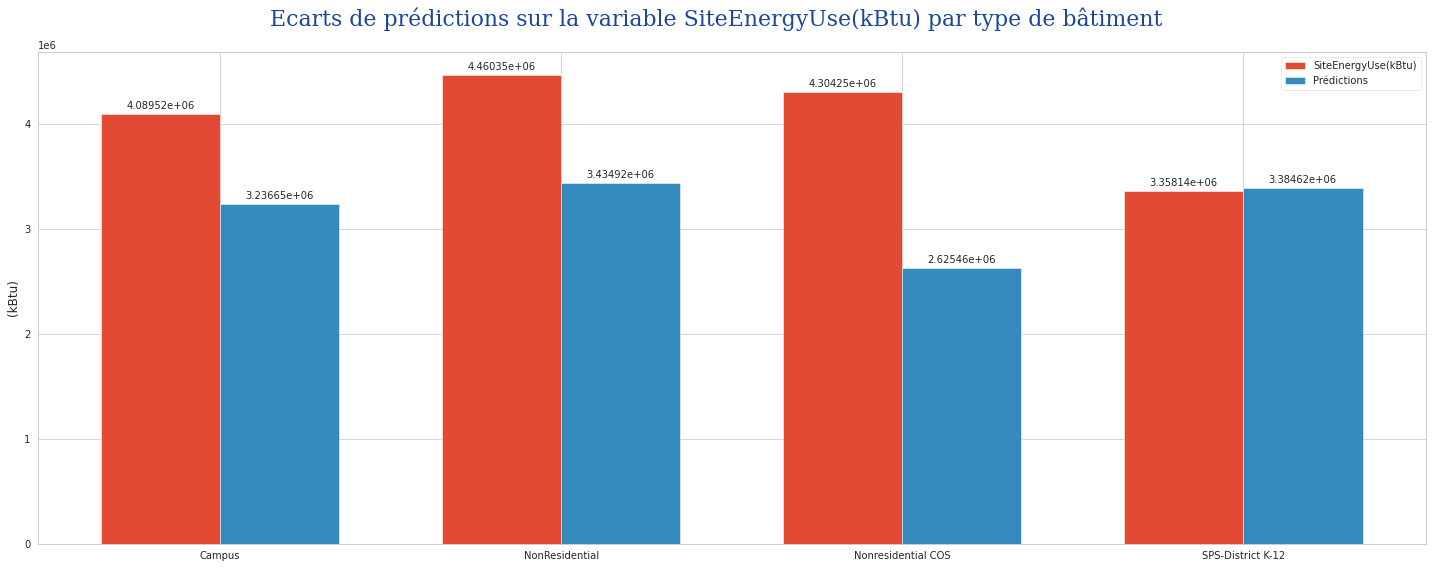

In [72]:
x = np.arange(len(compare_final_SEU_test.index))
width = 0.35

fig, ax = plt.subplots(figsize=(20,8), sharey=False, sharex=False)

scores1 = ax.bar(x - width/2, compare_final_SEU_test['SiteEnergyUse(kBtu)'], width, label='SiteEnergyUse(kBtu)')
scores2 = ax.bar(x + width/2, compare_final_SEU_test['SEU_pred'], width, label='Prédictions')
ax.set_ylabel('(kBtu)')
ax.set_xticks(x)
ax.set_xticklabels(compare_final_SEU_test.index)
ax.legend()
ax.bar_label(scores1, padding=3)
ax.bar_label(scores2, padding=3)

plt.suptitle("Ecarts de prédictions sur la variable SiteEnergyUse(kBtu) par type de bâtiment", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

### L'écart est très important sur la catégorie "Campus" qui est faiblement représentée dans le jeu de données mais qui présente les plus grandes consommations.

# 7. Influence du score ENERGY STAR
### Le score ENERGY STAR fournit un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 facile à comprendre : plus le score est élevé, meilleure est la performance énergétique du bâtiment.

###  Ce score permet de réaliser plusieurs actions :

### Évaluer les données énergétiques réelles facturées,
### Normaliser pour l'activité commerciale (heures, travailleurs, climat),
### Comparer les bâtiments à la population nationale,
### Indiquer le niveau de performance énergétique.
### Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.

In [73]:
#Ajout de la variable à nos variables X
X['energystar_score'] = energystar_score
#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')

In [74]:
#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['energystar_score'].isnull()==False]
Y = Y[Y.index.isin(list(X.index))]

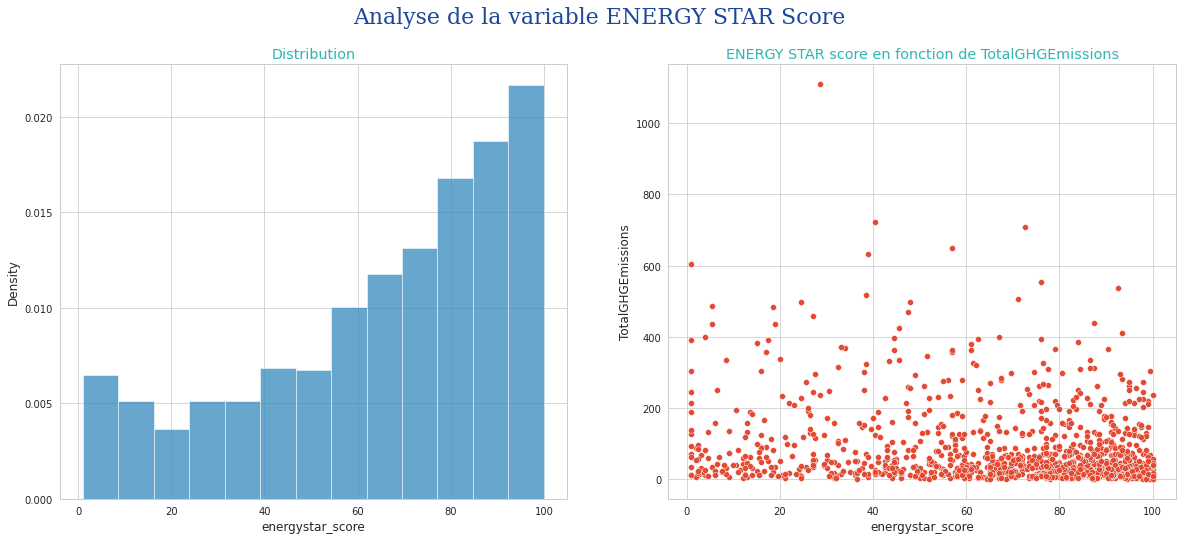

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", color='#2cb7b0')
sns.scatterplot(data=pd.concat([X,Y], axis=1), y='TotalGHGEmissions', x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de TotalGHGEmissions", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontdict=font_title, fontsize=22)
plt.show()

#### On remarque ici que le score ENERGY STAR ne semble pas avoir de corrélation importante avec les émissions de CO2. La distribution ne suit pas de loi normale et la majorité des batiments a un score supérieur à 50 (de bonne qualité voir de très bonne qualité).

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 857 lignes,
Test: 215 lignes.



#### On utilise ici le meilleur modèle calculé sur la variable TotalGHGEmissions en incluant l'ENERGY STAR Score :

In [77]:
rfr_grid_cv_eStar = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_eStar', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

GHG_rfr_model_eStar = rfr_grid_cv_eStar.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_rfr_results_eStar = model_scores(GHG_rfr_model_eStar, 'grid_search_rfr_eStar')

Meilleur score MAE : -44.913
Meilleur Score R2 : 0.422
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}
Temps moyen d'entrainement : 266.68s


In [78]:
GHG_pred_star = GHG_rfr_model_eStar.predict(X_test)
#Calcul des métriques pour les émissions de CO2
GHGmetricsES = metrics_model(Y_test['TotalGHGEmissions'],GHG_pred_star)
GHGmetrics = GHGmetrics.rename(columns={"Résultats" : "Sans ENERGY STAR"})
GHGmetrics['Avec ENERGY STAR'] = GHGmetricsES['Résultats']
GHGmetrics

,Métrique,Sans ENERGY STAR,Avec ENERGY STAR
0,MAE,3.397860e+06,41.306238
1,R²,-1.210860e+09,0.502815


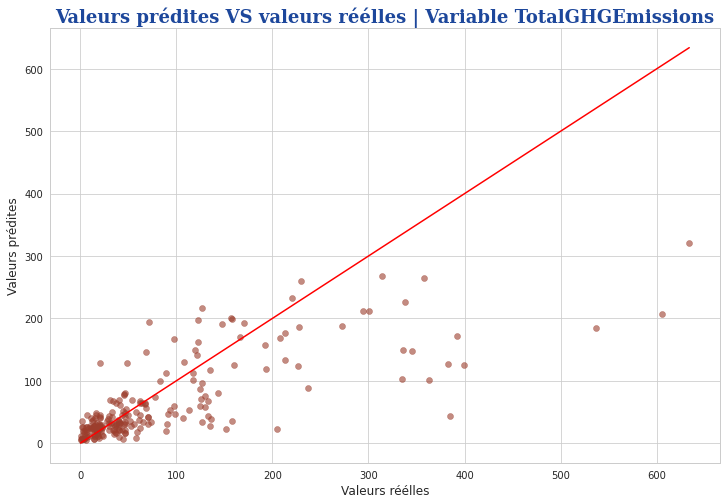

In [79]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['TotalGHGEmissions'],GHG_pred_star, color="#9C3E2D", title="TotalGHGEmissions")

#### Les valeurs prédites sont en effet beaucoup plus reserrées sur la première bissectrice et les métriques se sont améliorées grâce à la prise en compte de l'ENERGY STAR Score.

#### En revanche, cette variable est encore peu renseignée et le jeu de données comporte peu d'entrées. Il est donc difficile de savoir si cette amélioration est rééllement significative. Il faut également prendre en compte le bénéfice vis à vis du coût de cet ENERGY STAR Score